# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.chdir('../../')

In [3]:
from src.numpy_encode import *
from src.utils.file_processing import process_all, process_file
from src.config import *
from src.music_transformer import *
from src.multitask_transformer import *

In [4]:
config = mlm_config();

In [5]:
data_path = Path('data')

# Location of your midi files
midi_path = data_path/'midi'

# Location of transformed midi to numpy dataset
numpy_path = data_path/'numpy'/'combined_tracks'
data_save_name = 'multi_data_idxenc.pkl'

## MSKLM

In [6]:
data = load_data(numpy_path, data_save_name, bs=1)
vocab = data.vocab
learn = multitask_model_learner(data, config.copy())

## Load existing

In [7]:
saved_models = get_files(numpy_path/'models', recurse=True, extensions=['.pth']); saved_models

[PosixPath('data/numpy/combined_tracks/models/MusicTransformer.pth'),
 PosixPath('data/numpy/combined_tracks/models/MultitaskTransformer.pth')]

In [8]:
load_path = saved_models[1];
learn.load(load_path.stem);
load_path

PosixPath('data/numpy/combined_tracks/models/MultitaskTransformer.pth')

### Predictions - Get midi file

In [9]:
data_dir = 'data/midi/examples/'
midi_files = get_files(midi_path, recurse=True, extensions='.mid'); midi_files[:5]

[PosixPath('data/midi/examples/Levels - Avicii - Verse.mid'),
 PosixPath('data/midi/examples/Colors Of The Wind - Disney - Chorus.mid'),
 PosixPath('data/midi/examples/Where Is The Love - Black Eyed Peas - Chorus.mid'),
 PosixPath('data/midi/examples/La Bamba - Ritchie Valen - Chorus.mid'),
 PosixPath('data/midi/examples/I Want You Back - Jackson 5 - Intro.mid')]

In [10]:
idx = 2
file = midi_files[idx]; file

PosixPath('data/midi/examples/Where Is The Love - Black Eyed Peas - Chorus.mid')

In [11]:
# Encode file 
item = MusicItem.from_file(file, data.vocab)

x = item.to_tensor()
x_pos = item.get_pos_tensor()

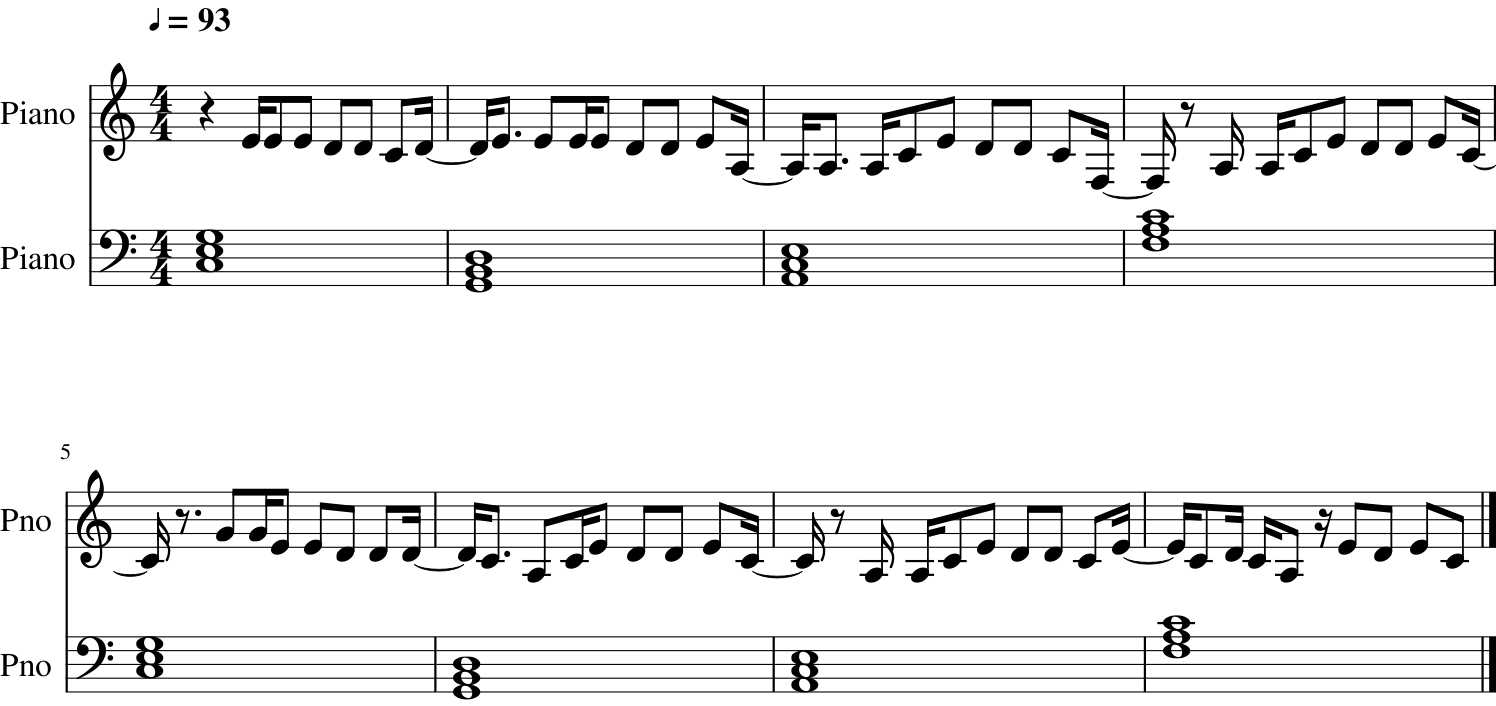

In [12]:
item.show()

In [13]:
item.play()

## Predict Mask

#### Regenerate durations

In [14]:
# duration mask
dur_item = item.mask_duration()

In [15]:
dur_pred = learn.predict_mask(dur_item, temperatures=(0.8,0.8), top_k=40, top_p=0.6)

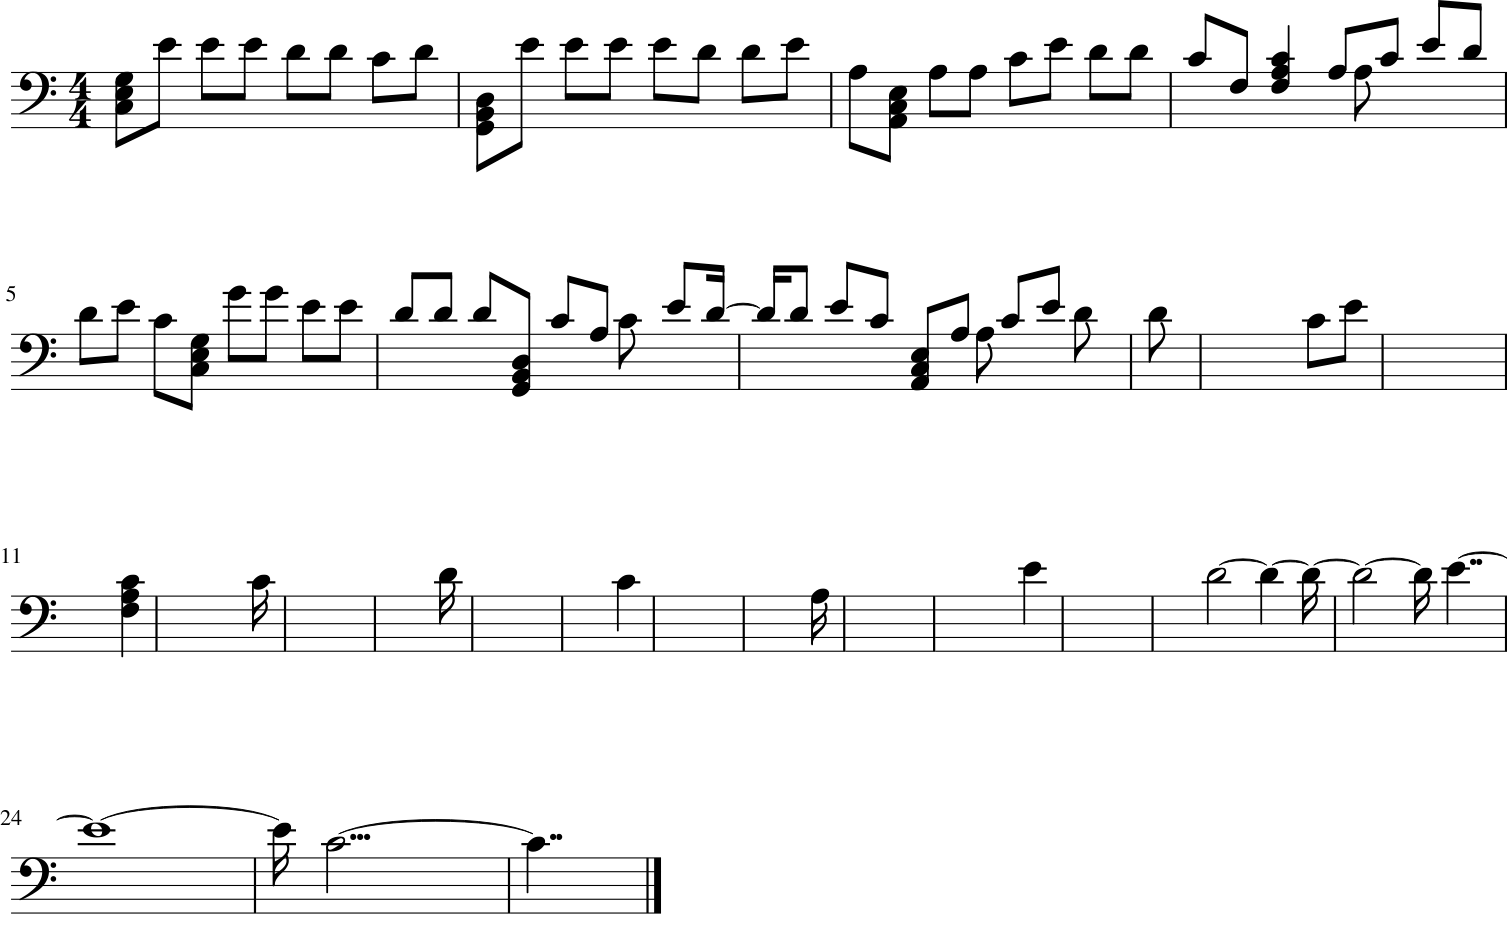

In [16]:
dur_pred.show()

#### Regenerate Notes

In [17]:
# Mask notes
# nr = vocab.stoi[SEP], vocab.stoi[NOTE_END]+1
note_item = item.mask_notes()
pred_note = learn.predict_mask(note_item)

pred_note.show()

IndexError: index 144 is out of bounds for axis 2 with size 128

In [19]:
pred_note.play()

IndexError: index 144 is out of bounds for axis 2 with size 128

In [20]:
out = mask_predict_from_midi(learn, file, predict_notes=True)

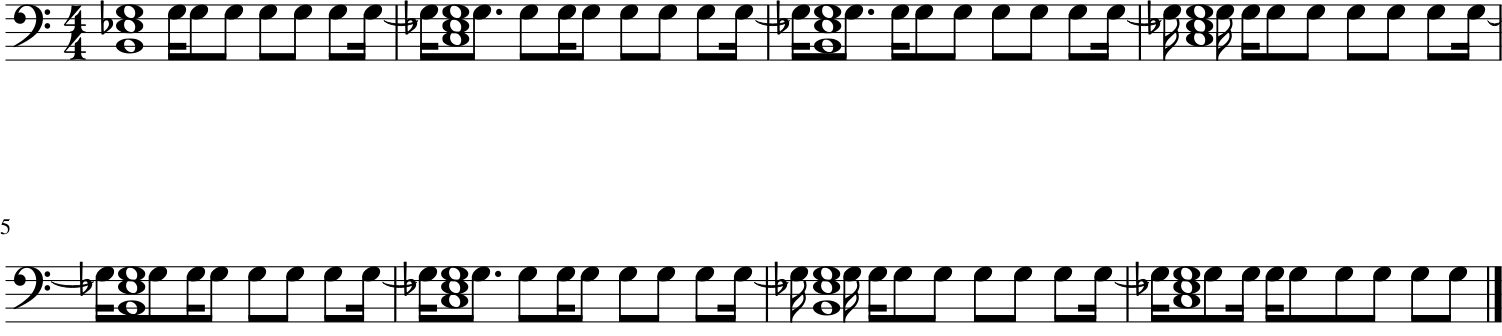

In [21]:
out.show()

## Prediction next word

In [22]:
seed_len = 4 # 4 beats = 1 bar
seed = item.trim_to_beat(seed_len)

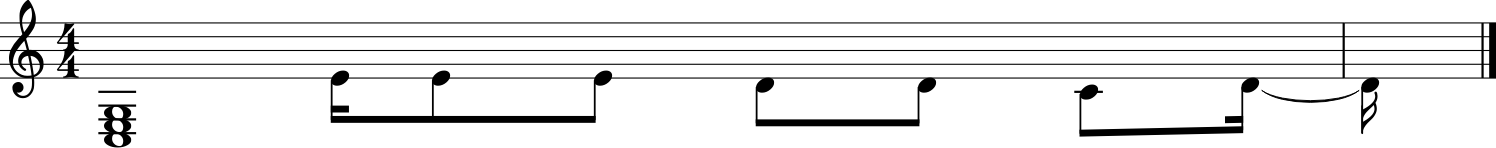

In [23]:
seed.show()

In [24]:
pred_nw = learn.predict_nw(seed, n_words=200)

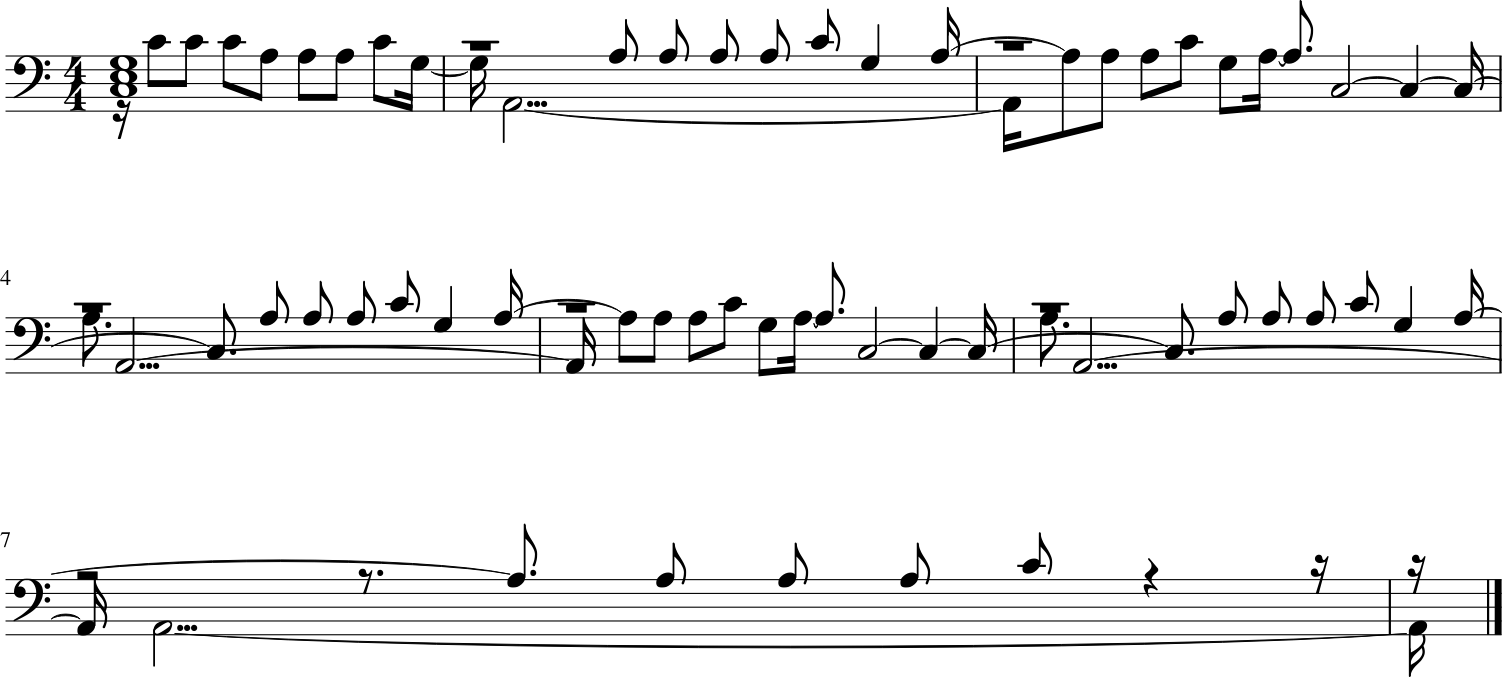

In [25]:
pred_nw.show()

In [26]:
pred_nw.play()

Convenience function

In [27]:
out = nw_predict_from_midi(learn, file, seed_len=seed_len, top_k=30, top_p=0.5)

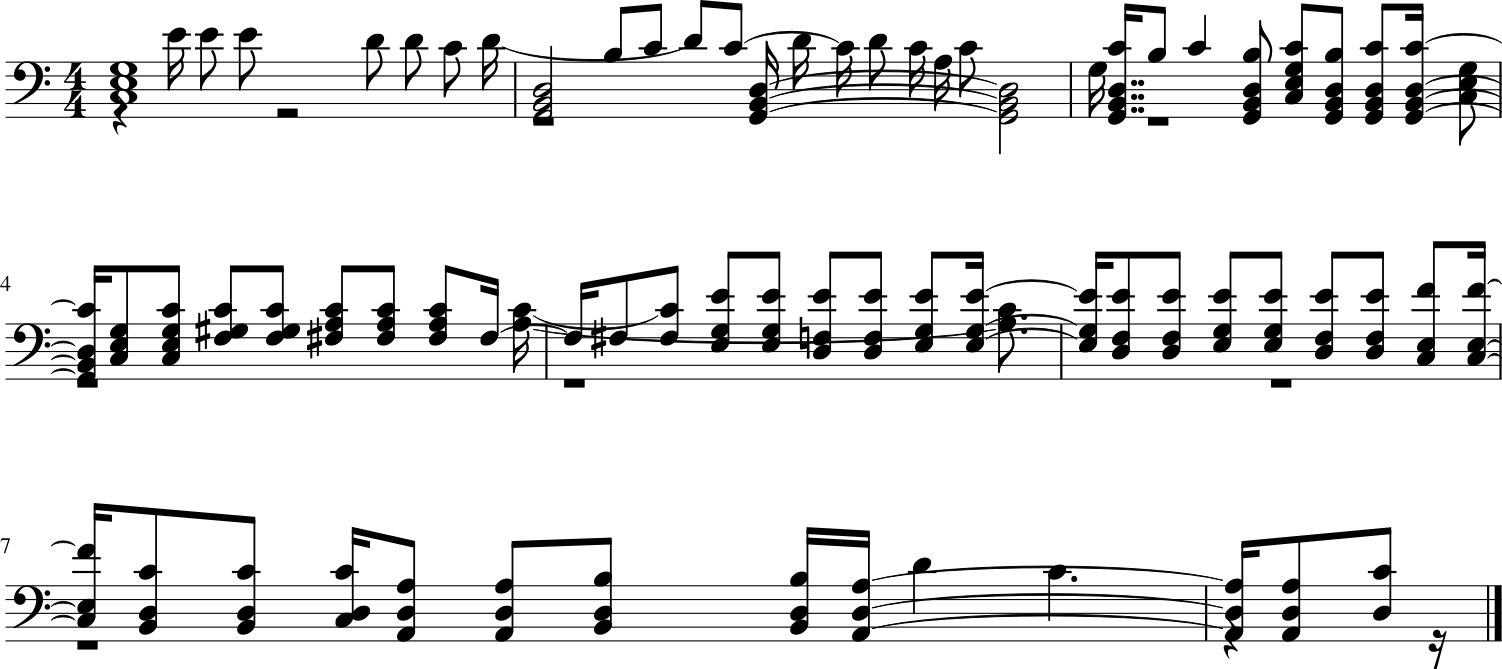

In [28]:
out.show()

## Predict Seq2Seq

In [29]:
from src.numpy_encode import stream2npenc_parts

In [35]:
multitrack_item = MultitrackItem.from_file(file, vocab)

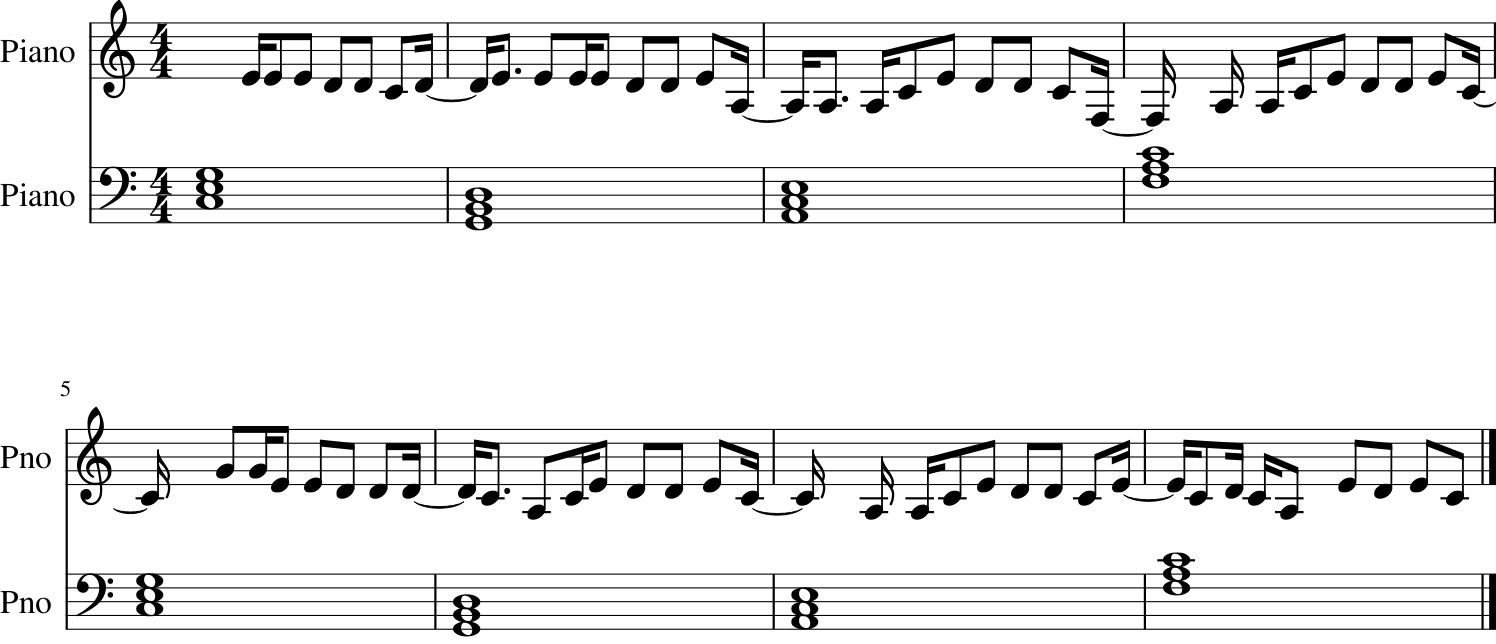

In [36]:
multitrack_item.show()

In [37]:
multitrack_item.play()

## Predict melody

In [38]:
melody, chords = multitrack_item.melody, multitrack_item.chords

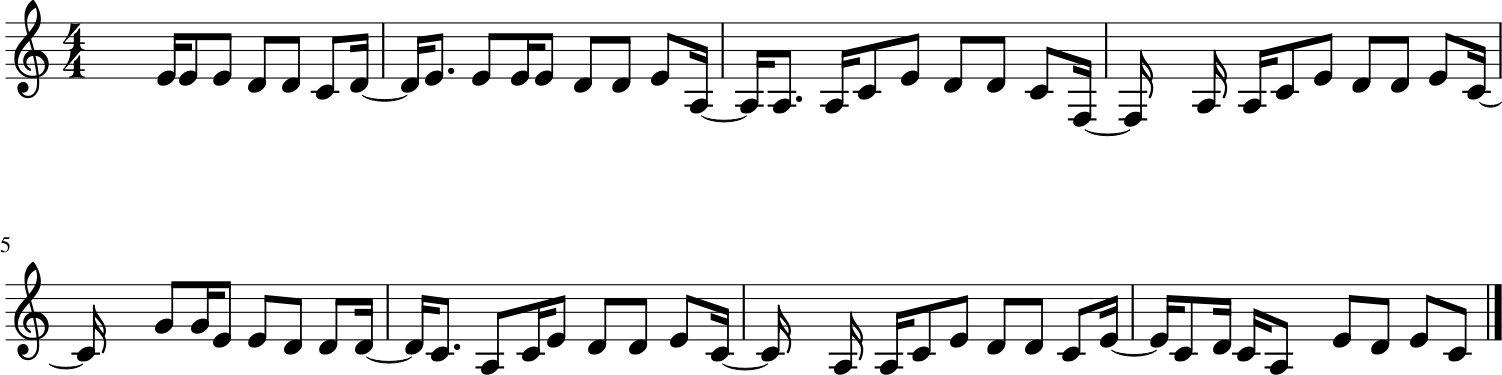

In [39]:
melody.show()

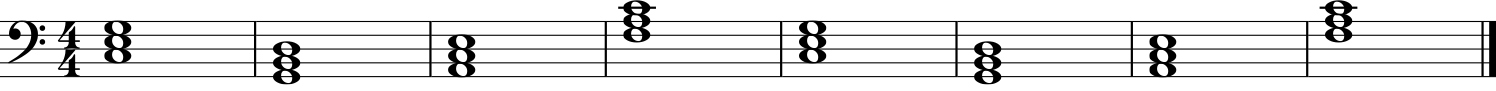

In [40]:
chords.show()

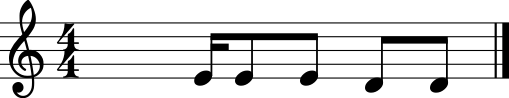

In [41]:
partial_melody = melody.trim_to_beat(3)
partial_melody.show()

In [44]:

def predict_s2s_fast(self, input_item:MusicItem, target_item:MusicItem, n_words:int=128,
                temperatures:float=(1.0,1.0),
                top_k=30, top_p=0.8):
    self.model.reset()
    vocab = self.data.vocab
    targ = target_item.data.tolist()
    targ_pos = target_item.position.tolist()
    last_pos = targ_pos[-1]

    # Input doesn't change. We can reuse the encoder output on each prediction
    inp, inp_pos = input_item.to_tensor()[None], input_item.get_pos_tensor()[None]
    x_enc = self.model.encoder(inp, inp_pos)

    max_pos = input_item.position[-1] - SAMPLE_FREQ * 4 # Only predict until both tracks/parts have the same length

    with torch.no_grad():
        for i in progress_bar(range(n_words), leave=True):

            # Next Word
            x, pos = torch.tensor(targ, device=x_enc.device)[None], torch.tensor(targ_pos, device=x_enc.device)[None]
            dec = self.model.decoder(x, pos, x_enc) # all tasks include mask decoding
            res = F.softmax(self.model.head(dec), dim=-1)[-1, -1]

            # Use first temperatures value if last prediction was duration
            temperature = temperatures[0] if (len(targ)==0 or vocab.is_duration(targ[-1])) else temperatures[1]
            if temperature != 1.: res.pow_(1 / temperature)

            res = top_k_top_p(res, top_k=top_k, top_p=top_p, filter_value=0)
            idx = torch.multinomial(res, 1).item()
            #         idx = res.argmax()

            if idx == vocab.bos_idx | idx == vocab.stoi[EOS]: 
                print('Predicting BOS/EOS')
                break

            if targ and targ[-1]==vocab.sep_idx: 
                duration = idx - vocab.dur_range[0]
                last_pos = last_pos - duration # position is negative
                if last_pos < max_pos:
                    print('Predicted past counter-part length. Returning early')
                    break

            targ_pos.append(last_pos)
            targ.append(idx)

    return vocab.musicify(np.array(targ))


In [45]:
pred_melody = learn.predict_s2s(chords, partial_melody)

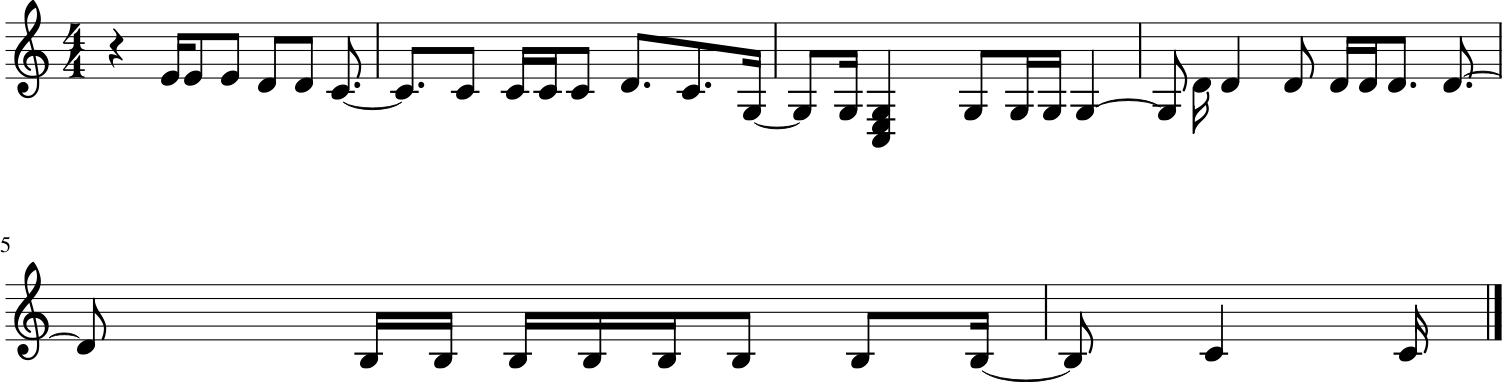

In [46]:
pred_melody.show()

In [47]:
combined = MultitrackItem(pred_melody, chords)

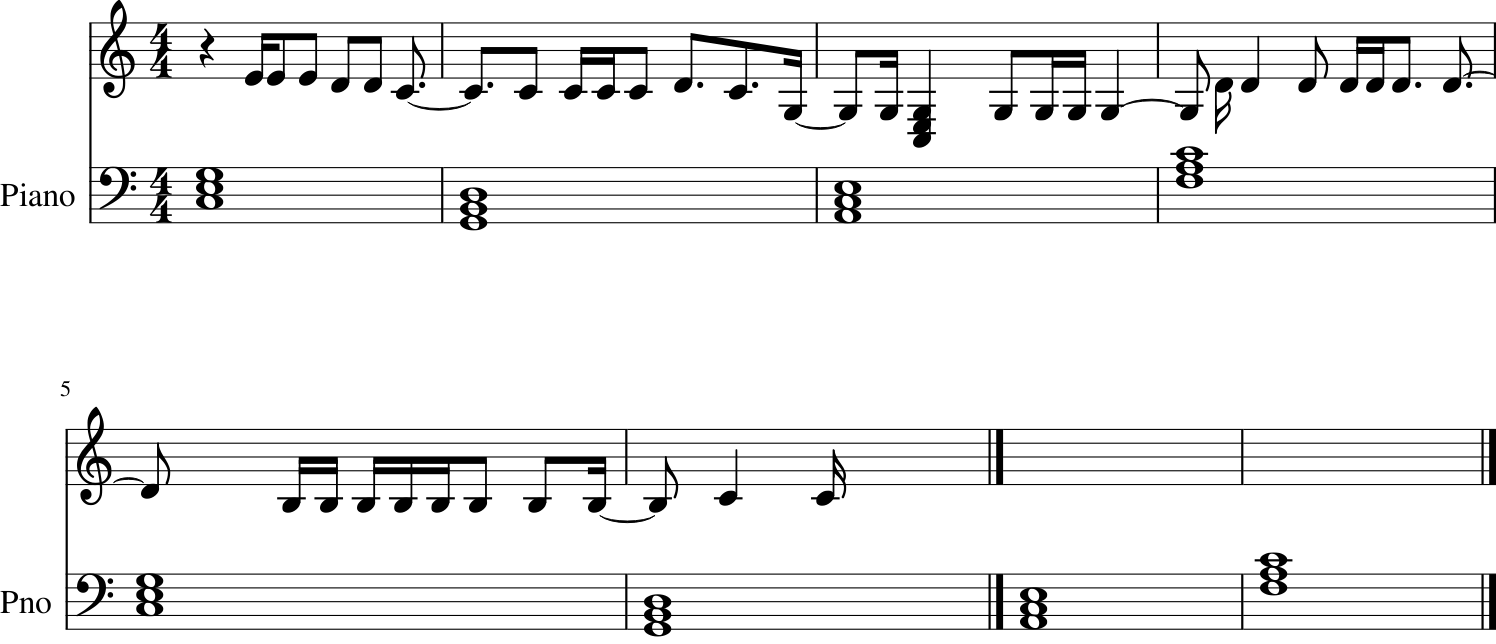

In [48]:
combined.show()

In [49]:
combined.play()

## Predict chords

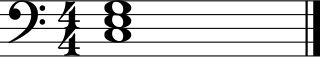

In [50]:
partial_chords = chords.trim_to_beat(3);
partial_chords.show()

In [56]:
pred_chord = learn.predict_s2s(input_item=melody, target_item=partial_chords)

Predicted past counter-part length. Returning early


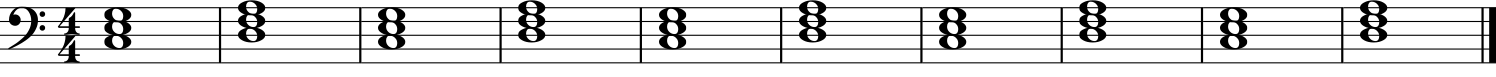

In [57]:
pred_chord.show()

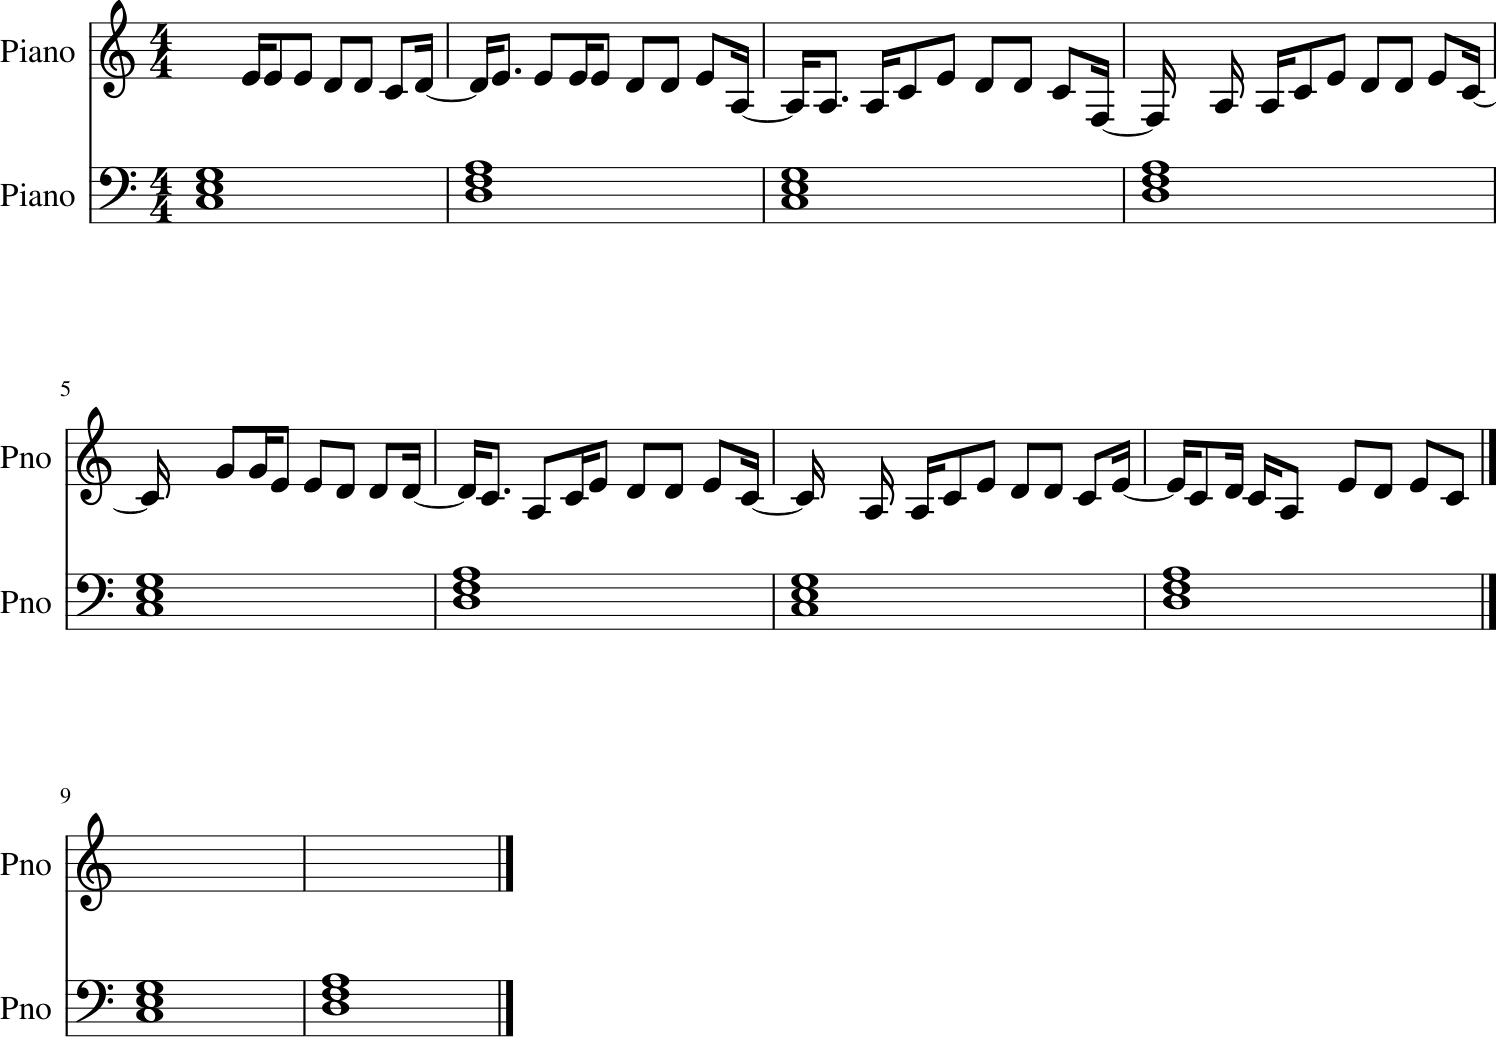

In [59]:
combined = MultitrackItem(melody, pred_chord)
combined.show()

Convenience Function

In [63]:
out = s2s_predict_from_midi(learn, file, seed_len=10)

Predicted past counter-part length. Returning early


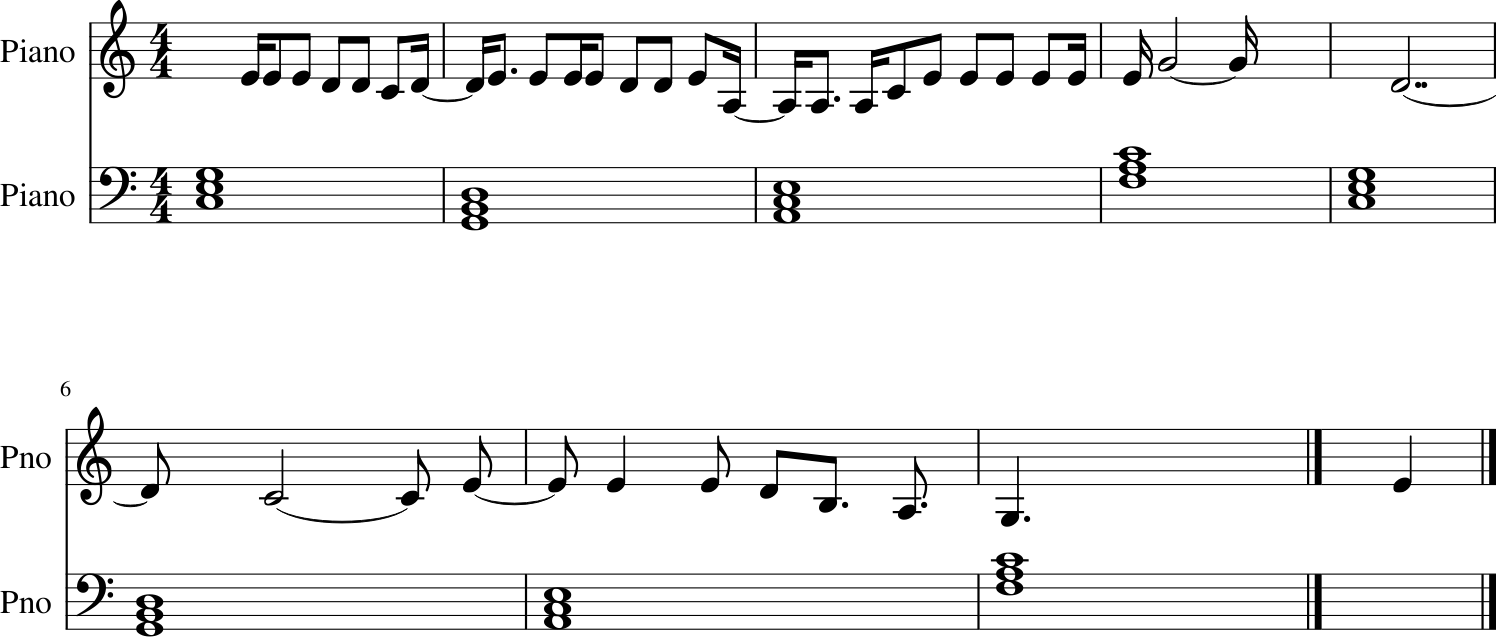

In [64]:
out.show()